In [11]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import datetime as dt
import math
import pmdarima as pm

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler

from IPython.display import Image

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages

df = pd.read_csv('C:/Users/pc/Downloads/energy (1).csv')

df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'
energy=df
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]



scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)



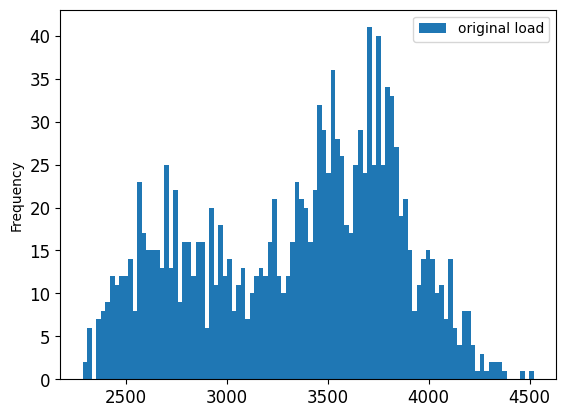

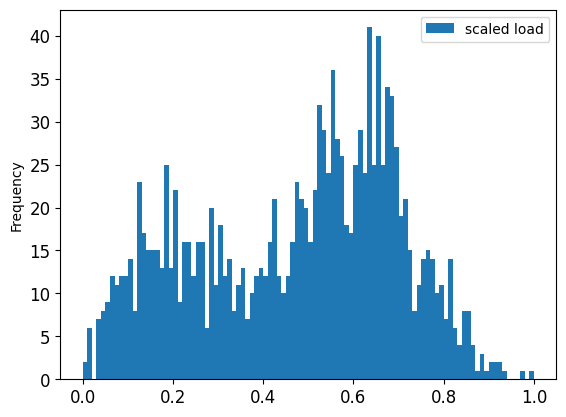

Forecasting horizon: 3 hours
2014-12-30 00:00:00
1 : predicted = [0.32 0.29 0.29] expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323, 0.26812891674127126]
2014-12-30 01:00:00
2 : predicted = [0.3  0.3  0.31] expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126, 0.3025962399283795]
2014-12-30 02:00:00
3 : predicted = [0.27 0.29 0.34] expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795, 0.40823634735899716]
2014-12-30 03:00:00
4 : predicted = [0.29 0.33 0.43] expected = [0.26812891674127126, 0.3025962399283795, 0.40823634735899716, 0.5689346463742166]
2014-12-30 04:00:00
5 : predicted = [0.29 0.39 0.55] expected = [0.3025962399283795, 0.40823634735899716, 0.5689346463742166, 0.6799462846911368]
2014-12-30 05:00:00
6 : predicted = [0.41 0.57 0.67] expected = [0.40823634735899716, 0.5689346463742166, 0.6799462846911368, 0.7309758281110115]
2014-12-30 06:00:00
7 : predicted = [0.57 0.68 0.73] expected = [0.5689346463742166, 0.67994

In [12]:
energy[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()
test['load'] = scaler.transform(test)
test.head()
# Specify the number of steps to forecast ahead

HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')

model = pm.auto_arima(train, seasonal=True, m=12, stepwise=True, suppress_warnings=True)
order = model.order
seasonal_order = model.seasonal_order
# Get the selected SARIMAX parameters
model = SARIMAX(train, order=order, seasonal_order=seasonal_order)

# model = pm.auto_arima(train['load'], seasonal=True, m=12)

results = model.fit()


test_shifted = test.copy()

for t in range(1, HORIZON+1):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')

test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)



training_window = 720 # dedicate 30 days (720 hours) for training

train_ts = train['load']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()



for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)




    

In [13]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

ValueError: Length of values (46) does not match length of index (45)